In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [47]:
!conda list statsmodels

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
statsmodels               0.13.1                   pypi_0    pypi


In [48]:
!pip uninstall statsmodels -y
!pip install -U statsmodels

Found existing installation: statsmodels 0.13.1
Uninstalling statsmodels-0.13.1:
  Successfully uninstalled statsmodels-0.13.1
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [122]:
from pathlib import Path
from itertools import cycle
from random import randint

from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from deap import creator as ga_cr, base as ga_b, algorithms as ga_algo, tools as ga_t

from sklearn.metrics import mean_squared_error

In [50]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [51]:
path = Path().cwd().parent / 'input'
files = list(path.rglob('*'))
files

[PosixPath('/kaggle/input/tabular-playground-series-jan-2022'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/train.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/test.csv')]

In [52]:
train = pd.read_csv(files[2])
train['date'] = pd.to_datetime(train['date'], errors='coerce')
train = train.set_index('date')

test = pd.read_csv(files[3])
test['date'] = pd.to_datetime(test['date'], errors='coerce')
test = test.set_index('date')

train
test

,row_id,country,store,product,num_sold
date,,,,,
2015-01-01,0,Finland,KaggleMart,Kaggle Mug,329
2015-01-01,1,Finland,KaggleMart,Kaggle Hat,520
2015-01-01,2,Finland,KaggleMart,Kaggle Sticker,146
2015-01-01,3,Finland,KaggleRama,Kaggle Mug,572
2015-01-01,4,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...
2018-12-31,26293,Sweden,KaggleMart,Kaggle Hat,823
2018-12-31,26294,Sweden,KaggleMart,Kaggle Sticker,250
2018-12-31,26295,Sweden,KaggleRama,Kaggle Mug,1004


,row_id,country,store,product
date,,,,
2019-01-01,26298,Finland,KaggleMart,Kaggle Mug
2019-01-01,26299,Finland,KaggleMart,Kaggle Hat
2019-01-01,26300,Finland,KaggleMart,Kaggle Sticker
2019-01-01,26301,Finland,KaggleRama,Kaggle Mug
2019-01-01,26302,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...
2019-12-31,32863,Sweden,KaggleMart,Kaggle Hat
2019-12-31,32864,Sweden,KaggleMart,Kaggle Sticker
2019-12-31,32865,Sweden,KaggleRama,Kaggle Mug


In [53]:
# Checking

def train_valid(df_wide):
    train_dfs, train_ids = {}, {}
    valid_dfs, valid_ids = {}, {}
    for cat in df_wide['country'].unique():
        for cat_ in df_wide['store'].unique():
            for cat__ in df_wide['product'].unique():
                mask = (df_wide['country']==cat) & (df_wide['store']==cat_) & (df_wide['product']==cat__)
                df = df_wide[mask]
                #train_ids[cat+cat_+cat__] = df['row_id']
                df = df.groupby(['country', 'store', 'product']).resample('D').sum()['num_sold']
                df = df.reset_index(level=[0,1,2], drop=True).squeeze()
                df.name = cat+cat_+cat__
                thresh = int(len(df)*0.8)
                df_train = df.iloc[:thresh]
                df_valid = df.iloc[thresh:]
                train_dfs[cat+cat_+cat__] = df_train
                valid_dfs[cat+cat_+cat__] = df_valid
                print(df_wide[mask].shape[0] == (df_train.shape[0] + df_valid.shape[0])) 
    return train_dfs, valid_dfs

train_dfs, valid_dfs = train_valid(train)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2018-03-14    187.935104
2018-03-15    185.701605
2018-03-16    196.568919
2018-03-17    234.764209
2018-03-18    241.927729
                 ...    
2019-03-09    234.764209
2019-03-10    241.927729
2019-03-11    172.250321
2019-03-12    174.905598
2019-03-13    187.935104
Freq: D, Name: FinlandKaggleMartKaggle Mug_f, Length: 365, dtype: float64

date
2018-03-14    217
2018-03-15    184
2018-03-16    193
2018-03-17    254
2018-03-18    244
             ... 
2018-12-27    414
2018-12-28    499
2018-12-29    774
2018-12-30    757
2018-12-31    469
Freq: D, Name: FinlandKaggleMartKaggle Mug, Length: 293, dtype: int64

,FinlandKaggleMartKaggle Mug,FinlandKaggleMartKaggle Mug_f
2018-03-14,217,187.935104
2018-03-15,184,185.701605
2018-03-16,193,196.568919
2018-03-17,254,234.764209
2018-03-18,244,241.927729
...,...,...
2018-12-27,414,185.701605
2018-12-28,499,196.568919
2018-12-29,774,234.764209
2018-12-30,757,241.927729


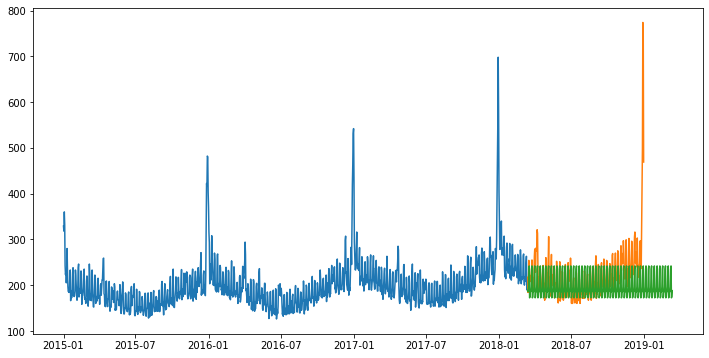

In [64]:
res = STLForecast(temp, ARIMA).fit()
forec = res.forecast(365)
forec.name = temp.name + '_f'
forec
temp_
pd.merge(left=temp_, right=forec, left_index=True, right_index=True)
#valid

fig, ax = plt.subplots(figsize=(12,6))
_ = ax.plot(temp)
_ = ax.plot(temp_)
_ = ax.plot(forec)

In [204]:
class GA_Statsmodels():
    def __init__(self, 
                 params, 
                 eval_func,
                 eval_weights,
                 #
                 train_df,
                 valid_df,
                 #
                 sel_tournsize=2,
                 cx_uniform_prob=0.5, 
                 mut_shuffle_idx_prob=0.1, 
                 n_pop=10, 
                 n_gen=10, 
                 n_hof=1, 
                 cx_prob=0.5, 
                 mut_prob=0.1, 
                 n_jobs=1
                ):
        self.params = params
        self.eval_func = eval_func
        self.eval_weights = eval_weights
        
        self.train_df = train_df
        self.valid_df = valid_df
        
        self.sel_tournsize = sel_tournsize
        self.cx_uniform_prob = cx_uniform_prob
        self.mut_shuffle_idx_prob = mut_shuffle_idx_prob
        self.n_pop = n_pop
        self.n_gen = n_gen
        self.n_hof = n_hof
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        
        self.n_jobs = n_jobs

        self._pad_params()
        self._create_fitness_and_indiv()
        self._register_indiv_and_pop_generators()
        self._register_eval_func()
        self._register_selection_crossover_mutation_methods()

    def _pad_params(self):
        """Pad params for crossover shuffle idx method"""
        assert isinstance(self.params, dict), 'Params must be a dict, i.e. estimator.get_params()'
        params_count = {k: len(v) for k,v in self.params.items()}
        max_length, max_key = -99, ''
        for k, v in params_count.items():
            if v <= max_length:
                continue
            else:
                max_key = k
                max_length = v
        assert isinstance(max_length, int), 'The max length between all params must be an int'
        # cycle through params for max length param, otherwise infinite cycle
        values_padded = (cycle(v) if k!=max_key else v for k,v in self.params.items())
        values_padded = zip(*values_padded)  # ('a', 1, 14), ('b', 2, 16), ('c', 3, 16) ...
        values_padded = zip(*values_padded)  # ('a', 'b', 'c'), (1, 2, 3), (14, 15, 16)...
        padded_params = {}
        for k, v in zip(self.params, values_padded):
            padded_params[k] = v
        self.padded_params = padded_params
        print('Params padded')

    def _create_fitness_and_indiv(self):
        """Create GA individual and fitness entities (classes)"""
        ga_cr.create('Fitness', ga_b.Fitness, weights=self.eval_weights)
        ga_cr.create('Individual', list, fitness=ga_cr.Fitness)
        print('GA entities created')

    def _gen_params_to_ga(self):
        """Generate index for each param for individual"""
        max_dict = len(self.padded_params)
        max_length = len(list(self.padded_params.values())[0])
        idxs = [randint(0, max_length-1) for _ in range(max_dict)]
        return idxs
    
    def _register_indiv_and_pop_generators(self):
        """Register GA individual and population generators"""
        self.tb = ga_b.Toolbox()

        if self.n_jobs > 1:
            from multiprocessing import Pool
            pool = Pool()
            self.tb.register("map", pool.map)

        self.tb.register("individual", ga_t.initIterate, ga_cr.Individual, self._gen_params_to_ga)
        #print('indiv', self.tb.individual())
        self.tb.register("population", ga_t.initRepeat, list, self.tb.individual)
        #print('population', self.tb.population(n=2))
        print('GA entities\' methods registered')
        
    def _register_eval_func(self):
        """Set GA evaluate individual function"""
        self.tb.register("evaluate",
                        self.eval_func,
                        padded_params=self.padded_params,
                        train_df=self.train_df,
                        valid_df=self.valid_df,
                        )
        #print(list(self.tb.evaluate(indiv) for indiv in self.tb.population(3)))
        print('GA eval function registered')
    
    def _register_selection_crossover_mutation_methods(self):
        self.tb.register("select", ga_t.selTournament, tournsize=self.sel_tournsize)
        self.tb.register("mate", ga_t.cxUniform, indpb=self.cx_uniform_prob)
        self.tb.register("mutate", ga_t.mutShuffleIndexes, indpb=self.mut_shuffle_idx_prob)
        print('GA sel-cx-mut methods registered')
        
    def run_ga_search(self):
        """GA Search"""
        pop = self.tb.population(n=self.n_pop)
        hof = ga_t.HallOfFame(self.n_hof)

        # Stats stdout
        stats = ga_t.Statistics(lambda ind: ind.fitness.values )
        #stats1 = ga_t.Statistics(lambda ind: ind.fitness.values[0] )
        #stats2 = ga_t.Statistics(lambda ind: ind.fitness.values[1] )
        #stats3 = ga_t.Statistics(lambda ind: ind.fitness.values[2] )
        stats = ga_t.MultiStatistics(accuracy=stats)
        stats.register("avg", np.mean)
        #stats.register("std", np.std)
        #stats.register("min", np.min)
        #stats.register("max", np.max)

        # History
        #hist = tools.History()
        #toolbox.decorate("select", hist.decorator)
        #tb.decorate("mate", hist.decorator)
        #tb.decorate("mutate", hist.decorator)
        #hist.update(pop)

        # GA Run
        pop, log = ga_algo.eaSimple(pop, self.tb, cxpb=self.cx_prob, 
                                    mutpb=self.mut_prob, ngen=self.n_gen, 
                                    stats=stats, halloffame=hof, verbose=True)
        
        # Convert back params
        hof_ = {}
        for i in range(self.n_hof):
            hof_['hof_' + str(i)] = self._ga_to_params(hof[i])

        return pop, log, hof_
    
    def _ga_to_params(self, idx_params):
        """Convert back idx to params"""
        res = {}
        for (k,v), idx in zip(self.padded_params.items(), idx_params):
            res[k] = v[idx]
        return res

In [206]:
helper = np.linspace(3, 100, 20).astype(int)

ts_params = {
    'ar': [0,1,2,3,4],
    'd': [0,1,2,3],
    'ma': [0,1,2,3,4],
    #'split': np.linspace(0.65, 0.9, num=10),
    'seasonal': helper[(helper%2)==True]
}

def ts_eval_indiv(individual, padded_params, train_df, valid_df):
    """Evaluate individual's genes (estimator's params)"""
    # Params
    p = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual)}
    
    # Data

    # Model
    try:
        res = STLForecast(train_df, 
                          ARIMA, 
                          model_kwargs={'order': (p['ar'], p['d'], p['ma'])},
                          seasonal=p['seasonal']
                         ).fit()
        forec = res.forecast(int(365*0.8))
        forec.name = train_df.name + '_F'
        valid = pd.merge(left=valid_df, right=forec, left_index=True, right_index=True)
        # TODO errors metrics
        err = mean_squared_error(valid.iloc[:, 0], valid.iloc[:, 1])
        
    except BaseException as e:
        print('=> Error:', e)
        return 1000000,

    # Risk
    #inputs = inputs.to(device)
    #risk = mean(prod(net(inputs)*10, dim=1))
    #if isnan(risk):
    #    risk = 10
    #else:
    #    risk = float(risk)
        
    # Complexity
    #compl = net.count_weights_biases()

    return (err,)

ts_weights = (-1,)

In [207]:
# testing
names = list(train_dfs.keys())
temp = train_dfs[names[0]]

names = list(valid_dfs.keys())
temp_ = valid_dfs[names[0]]

ga_ts = GA_Statsmodels(ts_params, ts_eval_indiv, ts_weights, temp, temp_)
pop, log, hof = ga_ts.run_ga_search()

Params padded
GA entities created
GA entities' methods registered
GA eval function registered
GA sel-cx-mut methods registered


/opt/conda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:60

   	      	           accuracy           
   	      	------------------------------
gen	nevals	avg        	gen	nevals
0  	10    	1.73938e+08	0  	10    
1  	0     	3565.16    	1  	0     


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parame

2  	6     	3391.8     	2  	6     


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3  	6     	3089.56    	3  	6     
4  	5     	2985.74    	4  	5     
5  	8     	2971.57    	5  	8     
6  	6     	2968.35    	6  	6     
7  	4     	2964.86    	7  	4     
8  	8     	2963.25    	8  	8     


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


9  	6     	112920     	9  	6     
10 	7     	2963.25    	10 	7     


In [209]:
list(hof['hof_0'].values())

[2, 1, 3, 79]

[2, 1, 3, 79]

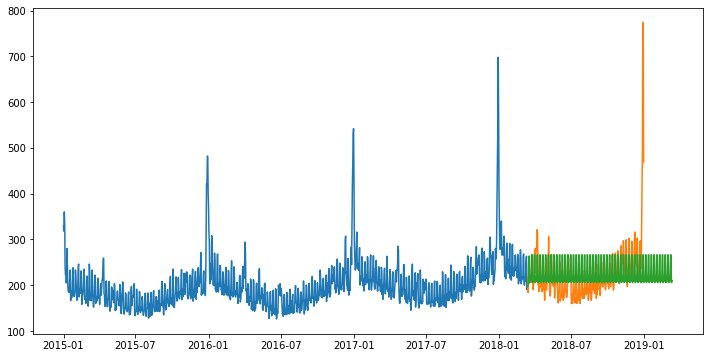

In [208]:
list(hof['hof_0'].values())
res = STLForecast(temp, 
                  ARIMA, 
                  model_kwargs={'order': list(hof['hof_0'].values())[:3] },
                 seasonal=list(hof['hof_0'].values())[3],
                 ).fit()
forec = res.forecast(365)
forec.name = temp.name + '_f'

fig, ax = plt.subplots(figsize=(12,6))
_ = ax.plot(temp)
_ = ax.plot(temp_)
_ = ax.plot(forec)

In [119]:
if False:
    res = ARIMA(temp, (2,2,0)).fit(disp=0)
    forec_periods = 24
    forec, stderr, conf_int = res.forecast(forec_periods)
    forec = pd.Series(forec, index=[temp.index.max()+pd.DateOffset(months=i+1) for i in range(forec_periods)])
    forec

    fig, ax = plt.subplots(figsize=(12,6))
    _ = ax.plot(temp)
    _ = ax.plot(forec)
    
    a = np.linspace(3, 50, 20).astype(int)
    a
    np.column_stack((
        a,
        (a%2)==True,
        a//2,
        (a//2)%2,
        ((a//2)%2)==True,
    ))
    a[(a%2)==True]